<a href="https://colab.research.google.com/github/wiltonbrayner23/Sanepar-python/blob/main/Compara%C3%A7%C3%A3o_das_t%C3%A9cnicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error, r2_score
from pandas import Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

In [8]:
df = pd.read_excel('https://github.com/wiltonbrayner23/Sanepar-python/blob/main/Time%20series%20jason%20brownlee.xlsx?raw=true')
df.set_index('Timestamp',inplace=True)
df = df.rename(columns={'BAIRRO ALTO -  / FREQ B1': 'FREQUENCIA BOMBA 1', 'BAIRRO ALTO -  / FREQ B2': 'FREQUENCIA BOMBA 2','BAIRRO ALTO -  / FREQ B3':'FREQUENCIA BOMBA 3','BAIRRO ALTO - LT01 / NÍVEL':'NIVEL DO RESERVATÓRIO - LT01','BAIRRO ALTO - FT01 / ENT IRAI':'VAZÃO DE ENTRADA- FT01','BAIRRO ALTO - FT02 / GBAL':'VAZÃO DE GRAVIDADE - FT02','BAIRRO ALTO - FT03 / RBAL':'VAZÃO DE RECALQUE - FT03','BAIRRO ALTO - PT01 / SUCÇÃO':'PRESSÃO DE SUCÇÃO - PT01','BAIRRO ALTO - PT02 / RBAL':'PRESSÃO DE RECALQUE - PT02'})
df.replace(to_replace='Bad', value=np.nan, inplace=True)
df.interpolate(inplace=True)
df = df.resample('1H').mean().reset_index()

In [9]:
df.set_index('Timestamp',inplace=True)
df.head()

,FREQUENCIA BOMBA 1,FREQUENCIA BOMBA 2,FREQUENCIA BOMBA 3,NIVEL DO RESERVATÓRIO - LT01,VAZÃO DE ENTRADA- FT01,VAZÃO DE GRAVIDADE - FT02,VAZÃO DE RECALQUE - FT03,PRESSÃO DE SUCÇÃO - PT01,PRESSÃO DE RECALQUE - PT02
Timestamp,,,,,,,,,
2018-01-01 00:00:00,39.716118,0.0,0.0,4.027903,270.285187,76.920532,61.992577,5.232423,13.961227
2018-01-01 01:00:00,40.692509,0.0,0.0,4.241524,268.635803,83.023201,66.538521,5.431031,13.961227
2018-01-01 02:00:00,34.512108,0.0,0.0,4.352295,0.000000,82.351860,57.269573,5.555567,11.049756
2018-01-01 03:00:00,33.531471,0.0,0.0,4.136808,0.000000,69.360985,52.244926,5.358496,11.115347
2018-01-01 04:00:00,33.191261,0.0,0.0,3.947308,0.000000,59.742775,49.718590,5.184939,11.180938


In [10]:
test_size = int(df.shape[0] * 0.3)
train_size = int(df.shape[0] * 0.7)
lags = 3 # tirar dúvida com a Vivi
colunas = df.columns

for lag in range(1, lags):
    for column in colunas:
        df[column + '_t-' + str(lag)] = df[column].shift(lag)

## 1 passo à frente

In [11]:
steps_ahead1 = 1
df['y'] = df['NIVEL DO RESERVATÓRIO - LT01'].shift(-steps_ahead1)
df.dropna(axis=0, inplace=True)
df.head()

,FREQUENCIA BOMBA 1,FREQUENCIA BOMBA 2,FREQUENCIA BOMBA 3,NIVEL DO RESERVATÓRIO - LT01,VAZÃO DE ENTRADA- FT01,VAZÃO DE GRAVIDADE - FT02,VAZÃO DE RECALQUE - FT03,PRESSÃO DE SUCÇÃO - PT01,PRESSÃO DE RECALQUE - PT02,FREQUENCIA BOMBA 1_t-1,...,FREQUENCIA BOMBA 1_t-2,FREQUENCIA BOMBA 2_t-2,FREQUENCIA BOMBA 3_t-2,NIVEL DO RESERVATÓRIO - LT01_t-2,VAZÃO DE ENTRADA- FT01_t-2,VAZÃO DE GRAVIDADE - FT02_t-2,VAZÃO DE RECALQUE - FT03_t-2,PRESSÃO DE SUCÇÃO - PT01_t-2,PRESSÃO DE RECALQUE - PT02_t-2,y
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 02:00:00,34.512108,0.0,0.0,4.352295,0.000000,82.351860,57.269573,5.555567,11.049756,40.692509,...,39.716118,0.0,0.0,4.027903,270.285187,76.920532,61.992577,5.232423,13.961227,4.136808
2018-01-01 03:00:00,33.531471,0.0,0.0,4.136808,0.000000,69.360985,52.244926,5.358496,11.115347,34.512108,...,40.692509,0.0,0.0,4.241524,268.635803,83.023201,66.538521,5.431031,13.961227,3.947308
2018-01-01 04:00:00,33.191261,0.0,0.0,3.947308,0.000000,59.742775,49.718590,5.184939,11.180938,33.531471,...,34.512108,0.0,0.0,4.352295,0.000000,82.351860,57.269573,5.555567,11.049756,3.832984
2018-01-01 05:00:00,34.850670,0.0,0.0,3.832984,283.889404,54.762260,49.945602,5.073123,12.047937,33.191261,...,33.531471,0.0,0.0,4.136808,0.000000,69.360985,52.244926,5.358496,11.115347,4.128683
2018-01-01 06:00:00,34.174210,0.0,0.0,4.128683,284.199951,55.226677,48.235146,5.375868,12.206452,34.850670,...,33.191261,0.0,0.0,3.947308,0.000000,59.742775,49.718590,5.184939,11.180938,4.389738


In [12]:
df_train = df.iloc[:-test_size, :]
df_test = df.iloc[-test_size:, :]

In [13]:
X_train = df_train.drop(['y'], axis=1)
y_train = df_train['y']
X_test = df_test.drop(['y'], axis=1)
y_test = df_test['y']

In [14]:
# Random Forest
model=RandomForestRegressor(n_estimators=30, min_samples_leaf=1, random_state=0, n_jobs=-1)

In [15]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30, n_jobs=-1, random_state=0)

In [16]:
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

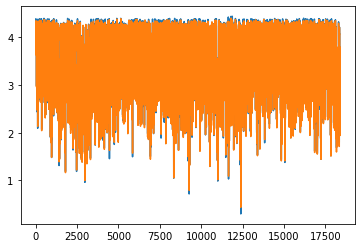

In [17]:
plt.plot(y_train.values, label='y_train')
plt.plot(y_hat_train, label='y_hat_train')

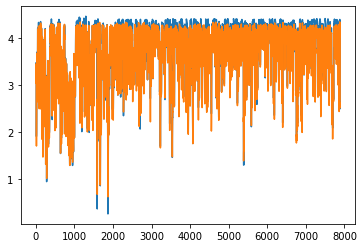

In [18]:
plt.plot(y_test.values, label='y_test')
plt.plot(y_hat_test, label='y_hat_test')

In [19]:
# Xgboost
model1 = XGBRegressor(
    random_state=0,
    learning_rate=0.08,
    n_estimators=1300,
    max_depth=6,
    min_child_weight=14,
    subsample=0.75,
    colsample_bytree=0.5,
    objective='reg:squarederror',
    booster='gbtree'
    )

In [20]:
model1.fit(X_train, y_train)

XGBRegressor(colsample_bytree=0.5, learning_rate=0.08, max_depth=6,
             min_child_weight=14, n_estimators=1300,
             objective='reg:squarederror', subsample=0.75)

In [21]:
y_hat_train1 = model1.predict(X_train)
y_hat_test1 = model1.predict(X_test)

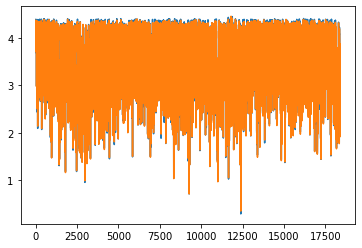

In [22]:
plt.plot(y_train.values, label='y_train')
plt.plot(y_hat_train1, label='y_hat_train')

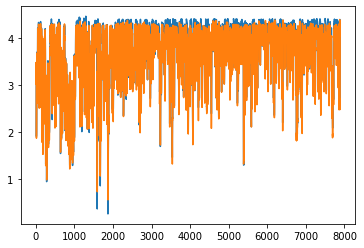

In [23]:
plt.plot(y_test.values, label='y_train')
plt.plot(y_hat_test1, label='y_hat_train')

In [ ]:
# holt winters
y_hat = []
y_train_aux=y_train
for i in range(y_test.shape[0]):
    holt1 = ExponentialSmoothing(y_train_aux, trend='add', seasonal_periods='mul').fit()
    y_hat_aux = holt1.forecast(steps_ahead1)
    y_hat.append(y_hat_aux)
    y_train_aux = y_train.append(y_test.iloc[:i])

A saída de streaming foi truncada nas últimas 5000 linhas.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginni

In [ ]:
plt.plot(y_test.values, label='y_test')
plt.plot(y_hat, label='y_hat')

In [ ]:
holt11 = ExponentialSmoothing(endog=y_train).fit()

y_hat_train2 = holt11.predict(start=0,end=(y_train.shape[0]-1))

In [ ]:
y_hat_train2.dropna(axis=0, inplace=True)

In [ ]:
# ARIMA
y_hat1 = []
y_train_aux1=y_train
for i in range(y_test.shape[0]):
    arima = ARIMA(y_train_aux1, order=(lags,0,5)).fit(disp=0)
    y_hat_aux1 = arima.forecast(steps_ahead1)[0][-1]
    y_hat1.append(y_hat_aux1)
    y_train_aux1 = y_train.append(y_test.iloc[:i])

In [ ]:
plt.plot(y_test.values, label='y_test')
plt.plot(y_hat1, label='y_hat')

In [ ]:
arima1 = ARIMA(y_train, order=(lags,0,5)).fit()

y_hat_train3 = arima1.predict()

In [ ]:
plt.plot(y_train.values, label='y_train')
plt.plot(y_hat_train3.values, label='y_hat')

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_train.values, label='Dados de Treino')
plt.plot(y_hat_train2.values, label='HoltWinters')
plt.plot(y_hat_train3.values, label='ARIMA')
plt.plot(y_hat_train1, label='Xgboost')
plt.plot(y_hat_train, label='Random Forest')
plt.legend(['Dados de treino','HoltWinters','ARIMA','Xgboost','Random Forest'])
plt.title('Comparação dados de treino considerando 1 passo à frente')

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_test.values, label='Dados de Teste')
plt.plot(y_hat, label='HoltWinters')
plt.plot(y_hat1, label='ARIMA')
plt.plot(y_hat_test1, label='Xgboost')
plt.plot(y_hat_test, label='Random Forest')
plt.legend(['Dados de teste','HoltWinters','ARIMA','Xgboost','Random Forest'])
plt.title('Comparação dados de teste considerando 1 passo à frente')